<h1>Toxic Comments Analysis</h1>
<ul>
    <li><a href="#2" style="text-decoration: none;">Why we are working about?</a></li>
    <li><a href="#3" style="text-decoration: none;">What data we used?</a></li>
    <li>
        <ul>
            <li><a href="#4" style="text-decoration: none;">Load Python libray and Data</a></li>
            <li><a href="#5" style="text-decoration: none;">Preprocess and Visualization</a></li>
            <li><a href="#6" style="text-decoration: none;">Text Preprocess</a></li>
            <li><a href="#7" style="text-decoration: none;">Feature Extraction and Prediction</a></li>
        </ul>
    </li>
</ul>

<h3 id='2'>Why we are predicting?</h3>
<p>Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.</p>

<h3 id='3'>What data is avaiable</h3>
<p>To analys the toxic comment, we have used <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data">Kaggle Dataset</a>. Although I do not used full set of data.</p>

<h3 id='4'>Load Python libray and Data</h3>

In [1]:
%matplotlib inline
import re
import nltk
import numpy as np
import pandas as pd
from num2words import num2words
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
print("Done")

Done


In [10]:
df = pd.read_csv('data/train.csv', encoding = "ISO-8859-1")

<h3 id='5'>Preprocess and Visualization</h3>

In [11]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
df = df.drop(['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [19]:
X = df.comment_text # Select the text column
y = df[df.columns[1:7]] # Select all labels of toxic

In [43]:
print(X.shape)
print(y.shape)

(14425,)
(14425, 6)


In [21]:
categorys = list(y.columns)
counts = []
for category in categorys:
    counts.append((category, y[category].sum()))
numbeOfComments = pd.DataFrame(counts, columns=['Category', 'Number_of_Comments'])
numbeOfComments

,Category,Number_of_Comments
0,toxic,1378
1,severe_toxic,154
2,obscene,754
3,threat,50
4,insult,724
5,identity_hate,128


Text(0, 0.5, 'Comments')

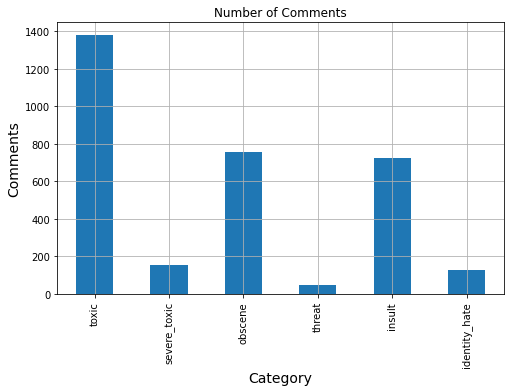

In [25]:
numbeOfComments.plot(x='Category', y='Number_of_Comments', kind='bar', legend = False, grid = True, figsize=(8,5))
plt.title('Number of Comments')
plt.xlabel('Category', fontsize = 14)
plt.ylabel('Comments', fontsize = 14)

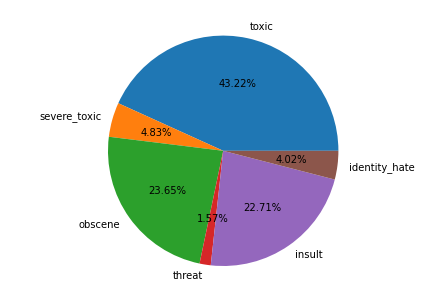

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(numbeOfComments['Number_of_Comments'], labels = numbeOfComments['Category'],autopct='%1.2f%%')
plt.show()

In [36]:
rowsums = y.iloc[:].sum(axis=1)
cont = rowsums.value_counts()
cont

0    12967
1      561
3      369
2      318
4      171
5       34
6        5
dtype: int64

<p><b>Here we can, there is 12967 comment is not toxic, 561 comment for one toxic label, and 361, 318, 171, 34, 5 comment for 3,2,4,5,6 sequentially.</b></p>

<AxesSubplot:>

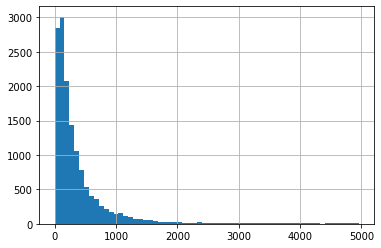

In [39]:
lens = df.comment_text.str.len() #The length of string in every comment
lens.hist(bins= np.arange(0, 5000,80))

<h3 id='6'>Text preprocessing</h3>

In [45]:
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from num2words import num2words
import unidecode

comments = []
stemmer = WordNetLemmatizer()
for sen in range(0,len(X)):
    comment = re.sub(r'<.*?>', ' ',str(X[sen])) # Remove the HTML tag 
    comment = re.sub(r'https?://\S+|www\.\S+', ' ', comment) # Remove URL
    
    comment = re.sub(r'\W', ' ', comment) # Removing all of the charecter except word charecter and digits, 
                                                #namely $ % &
    comment = re.sub(r'\s+[a-zA-Z]\s+', ' ', comment) # remove all single character, namely a b k h 
    comment = re.sub(r'^[a-zA-Z]\s+', ' ', comment) # removing single character from start of sentance
    comment = re.sub(r'\s+', ' ', comment, flags=re.I) # Convert multiple space to single
    comment = unidecode.unidecode(comment)
    comment = comment.lower()
    comment = comment.split()
    
    # Convert digit to word
    for index in range(len(comment)):
        if comment[index].isdigit():
            comment[index] = num2words(comment[index])
    '''        
    # Spelling Correction
    misSpelled_words = SpellChecker().unknown(comment)
    for index in range(len(comment)):
        if comment[index] in misSpelled_words:
            comment[index] = SpellChecker().correction(comment[index])
    '''        
    comment = [stemmer.lemmatize(word) for word in comment]
    # Using lemmatize Remove inflections and map a word to its root form. 
    # For instance trouble-> trouble, troubling -> trouble, troubled -> trouble
    comment = ' '.join(comment)
    comments.append(comment)
print('Done')

Done


In [47]:
from sklearn.model_selection import train_test_split
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df['comment_text']=comments
train, test = train_test_split(df, random_state=24, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(9664,)
(4761,)


<h3 id='7'>Feature Extraction and Prediction</h3>

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
analyzers = ['word','char','char_wb']
for anlyz in analyzers:
    accuracyScore = []
    accScore = 0
    NB_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(max_features = 1500, analyzer=anlyz, min_df = 5, max_df = 0.7, stop_words = stopwords.words('english'))),
                    ('clf', OneVsRestClassifier(SVC(gamma='auto'))),
                ])
    print('=' * 80)
    print("For {} Analyzer:".format(anlyz))
    for category in categories:
        NB_pipeline.fit(X_train, train[category])
        prediction = NB_pipeline.predict(X_test)
        accScore = accuracy_score(test[category], prediction)
        print('{0} test Result: {1}'.format(category,accScore ))
        accuracyScore.append(accScore)
    print('Mean {}\n'.format(np.mean(accuracyScore)))

For word Analyzer:
toxic test Result: 0.9042218021424071
severe_toxic test Result: 0.9888678848981306
obscene test Result: 0.947069943289225
threat test Result: 0.9955891619407687
insult test Result: 0.9510607015332914
identity_hate test Result: 0.9918084436042848
Mean 0.9631029895680179

For char Analyzer:
toxic test Result: 0.9042218021424071
severe_toxic test Result: 0.9888678848981306
obscene test Result: 0.947069943289225
threat test Result: 0.9955891619407687
insult test Result: 0.9510607015332914
identity_hate test Result: 0.9918084436042848
Mean 0.9631029895680179

For char_wb Analyzer:
toxic test Result: 0.9042218021424071
severe_toxic test Result: 0.9888678848981306
obscene test Result: 0.947069943289225
threat test Result: 0.9955891619407687
insult test Result: 0.9510607015332914
identity_hate test Result: 0.9918084436042848
Mean 0.9631029895680179

